# Notebook for testing the algorithms under Google colab

## 1. Introduction
The algorithms are defined in the publication:
    Javier Sánchez, The Inverse Compositional Algorithm for Parametric Registration, Image Processing On Line, 6 (2016), pp. 212–232. https://doi.org/10.5201/ipol.2016.153

The algorithms are implemented in Python as a result of a translation from the original C++ code released by the author.
The repository used here contains a dataset with images and the ground truth transformations to test the algorithms, as the ones available in the online demo on IPOL: https://ipolcore.ipol.im/demo/clientApp/demo.html?id=153
This enable users of this notebook to check easily the validity of the python implementation.

## 2.Test of algorithms

In [1]:
import matplotlib.pyplot as plt
import imageio
import os
import sys

print(os.getcwd())
sys.path.append(os.path.abspath("../src/"))
from inverse_compositional_algorithm import inverse_compositional_algorithm, robust_inverse_compositional_algorithm, pyramidal_inverse_compositional_algorithm
import configuration_handler as cfh
import image_optimisation as io

/mnt/git/computational_astro/inverse_compositional_algorithm/test


### Preparation of the configuration file

We create a configuration file with the meta parameters for the algorithm. 

In [2]:
cfh.create_config_file("config.ini")
# reading the parameters from the configuration file
params = cfh.read_config_file("config.ini")
params_ica = params["inverse_compositional_algorithm"]
params_rica = params["robust_inverse_compositional_algorithm"]
params_pica = params["pyramidal_inverse_compositional_algorithm"]

# define a dict with image filename and transformation ground truth

# calling the pipeline
# output_img, debug_dict = process(pic_root, options, params)


### Preparation of the dataset

In [3]:
import transformation as tf
import numpy as np
import os.path as path

In [4]:
dataset = {
    "rubber_whale": {
        "filename": "rubber_whale.png",
        "transformation_type": tf.TransformType.AFFINITY,
        "gt": [0.5, -0.5, -0.09, -0.1, -0.1, 0.05] # [tx,ty,a00,a01,a10,a11]
    },
    "mandrill": {
        "filename": "mandrill.tiff",
        "transformation_type": tf.TransformType.SIMILARITY,
        "gt": [0., 0., 0., 0.] # [tx, ty, a, b] -> IDENTITY
    },
    "lena": {
        "filename": "lena_color.tiff",
        "transformation_type": tf.TransformType.EUCLIDEAN,
        "gt": [0., 0., -0.1] # [tx, ty, theta] -> ROTATION, theta in radians and counterclockwise
    },
    "hydrangea": {
        "filename": "hydrangea.png",   
        "transformation_type": tf.TransformType.SIMILARITY,
        "gt": [38.798, 14.102, -0.10112, -0.044981] # [tx, ty, a, b] -> ZOOM+ROTATION+TRANSLATION
    },
    "dimetrodon": {
        "filename": "dimetrodon.png",
        "transformation_type": tf.TransformType.SIMILARITY,
        "gt": [47.944, -5.9639, -0.1045, 0.08985] # [tx, ty, a, b] -> ZOOM+ROTATION
    },
}

**Important note:**
The gt parameters are taken from the online demo of the original software. Please note that in the online demo, the source image is the one that is transformed.
So, I_transformed = params2matrix(gt) * I_source 
We need to invert the transformation to get the correct transformation for the python implementation.

In [5]:
print("The current directory is: ", os.getcwd())
image_path = os.path.join(os.getcwd(), "data")

The current directory is:  /mnt/git/computational_astro/inverse_compositional_algorithm/test


In [6]:
from skimage import transform

# We  implement here a specific transformation to generate the ground truth as in the online demo
# In the online demo, the ground truth transformation is to transform the source image to the target image
# But the source image is a transformed version of the original image given in the file.
# The transformation to pass from the original image to the source image is not given by the authors, but
# it seems to be the inverse of the gt given
# It means that given the gt transformation, to generate the source image, we have to apply the inverse of the gt
# and inverse the transformation again. In the end we can compute the source image as: source = gt * original
# To not confuse users where we generally apply the inverse of the matrix to see the transformed image in the coordinate
# system of the original, we propose a specifc function here
# def generate_source_image(original_image, transformation_type, gt):
#     if all(np.abs(value) < 1e-10 for value in gt):
#         # Identity transformation
#         tform = transform.AffineTransform(matrix=np.eye(3))
#     else:
#         hmatrix = tf.params2matrix(gt, transformation_type)
#         if transformation_type == tf.TransformType.AFFINITY:
#             tform = transform.AffineTransform(matrix=hmatrix)
#         elif transformation_type == tf.TransformType.SIMILARITY:
#             tform = transform.SimilarityTransform(matrix=hmatrix)
#         elif transformation_type == tf.TransformType.EUCLIDEAN:
#             tform = transform.EuclideanTransform(rotation=gt[2], translation=(gt[0], gt[1]))
#             # tform = transform.EuclideanTransform(matrix=hmatrix)
#         elif transformation_type == tf.TransformType.HOMOGRAPHY:
#             tform = transform.ProjectiveTransform(matrix=hmatrix)
#         else:
#             raise ValueError("Unsupported transformation type")

#     # this is what is specific here, because we don't apply the inverse of the transformation as we usually do
#     source_image = transform.warp(original_image, tform)
#     return source_image


**Update**:
The authors of the original software and of the online demo, provide the gt transformation from the source image to the transformed image. But the source image is already transformed compared to the original image. I have not been able to recover the transformation from the original to the source and from the source to the transformed.

So for my test, I will use the original image as the source, transformed with the given gt given in the online demo. Inputs are then different from the online demo, but the matter is to verify the correctness of the gt computation.

Dataset image:  rubber_whale
	Filename:  rubber_whale.png
	Image shape:  (388, 584, 3)
i:  0
gt [0.5, -0.5, -0.09, -0.1, -0.1, 0.05]
tform [[ 0.91 -0.1   0.5 ]
 [-0.1   1.05 -0.5 ]
 [ 0.    0.    1.  ]]
Dataset image:  mandrill
	Filename:  mandrill.tiff
	Image shape:  (512, 512, 3)
i:  1
gt [0.0, 0.0, 0.0, 0.0]
tform [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Dataset image:  lena
	Filename:  lena_color.tiff
	Image shape:  (512, 512, 3)
i:  2
gt [0.0, 0.0, -0.1]
tform [[ 0.99500417  0.09983342  0.        ]
 [-0.09983342  0.99500417  0.        ]
 [ 0.          0.          1.        ]]


/tmp/ipykernel_238028/2206014143.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(path.join(image_path, dataset[sample]["filename"]))


Dataset image:  hydrangea
	Filename:  hydrangea.png
	Image shape:  (388, 584, 3)
i:  3
gt [38.798, 14.102, -0.10112, -0.044981]
tform [[ 0.89888   0.044981 38.798   ]
 [-0.044981  0.89888  14.102   ]
 [ 0.        0.        1.      ]]
Dataset image:  dimetrodon
	Filename:  dimetrodon.png
	Image shape:  (388, 584, 3)
i:  4
gt [47.944, -5.9639, -0.1045, 0.08985]
tform [[ 0.8955  -0.08985 47.944  ]
 [ 0.08985  0.8955  -5.9639 ]
 [ 0.       0.       1.     ]]


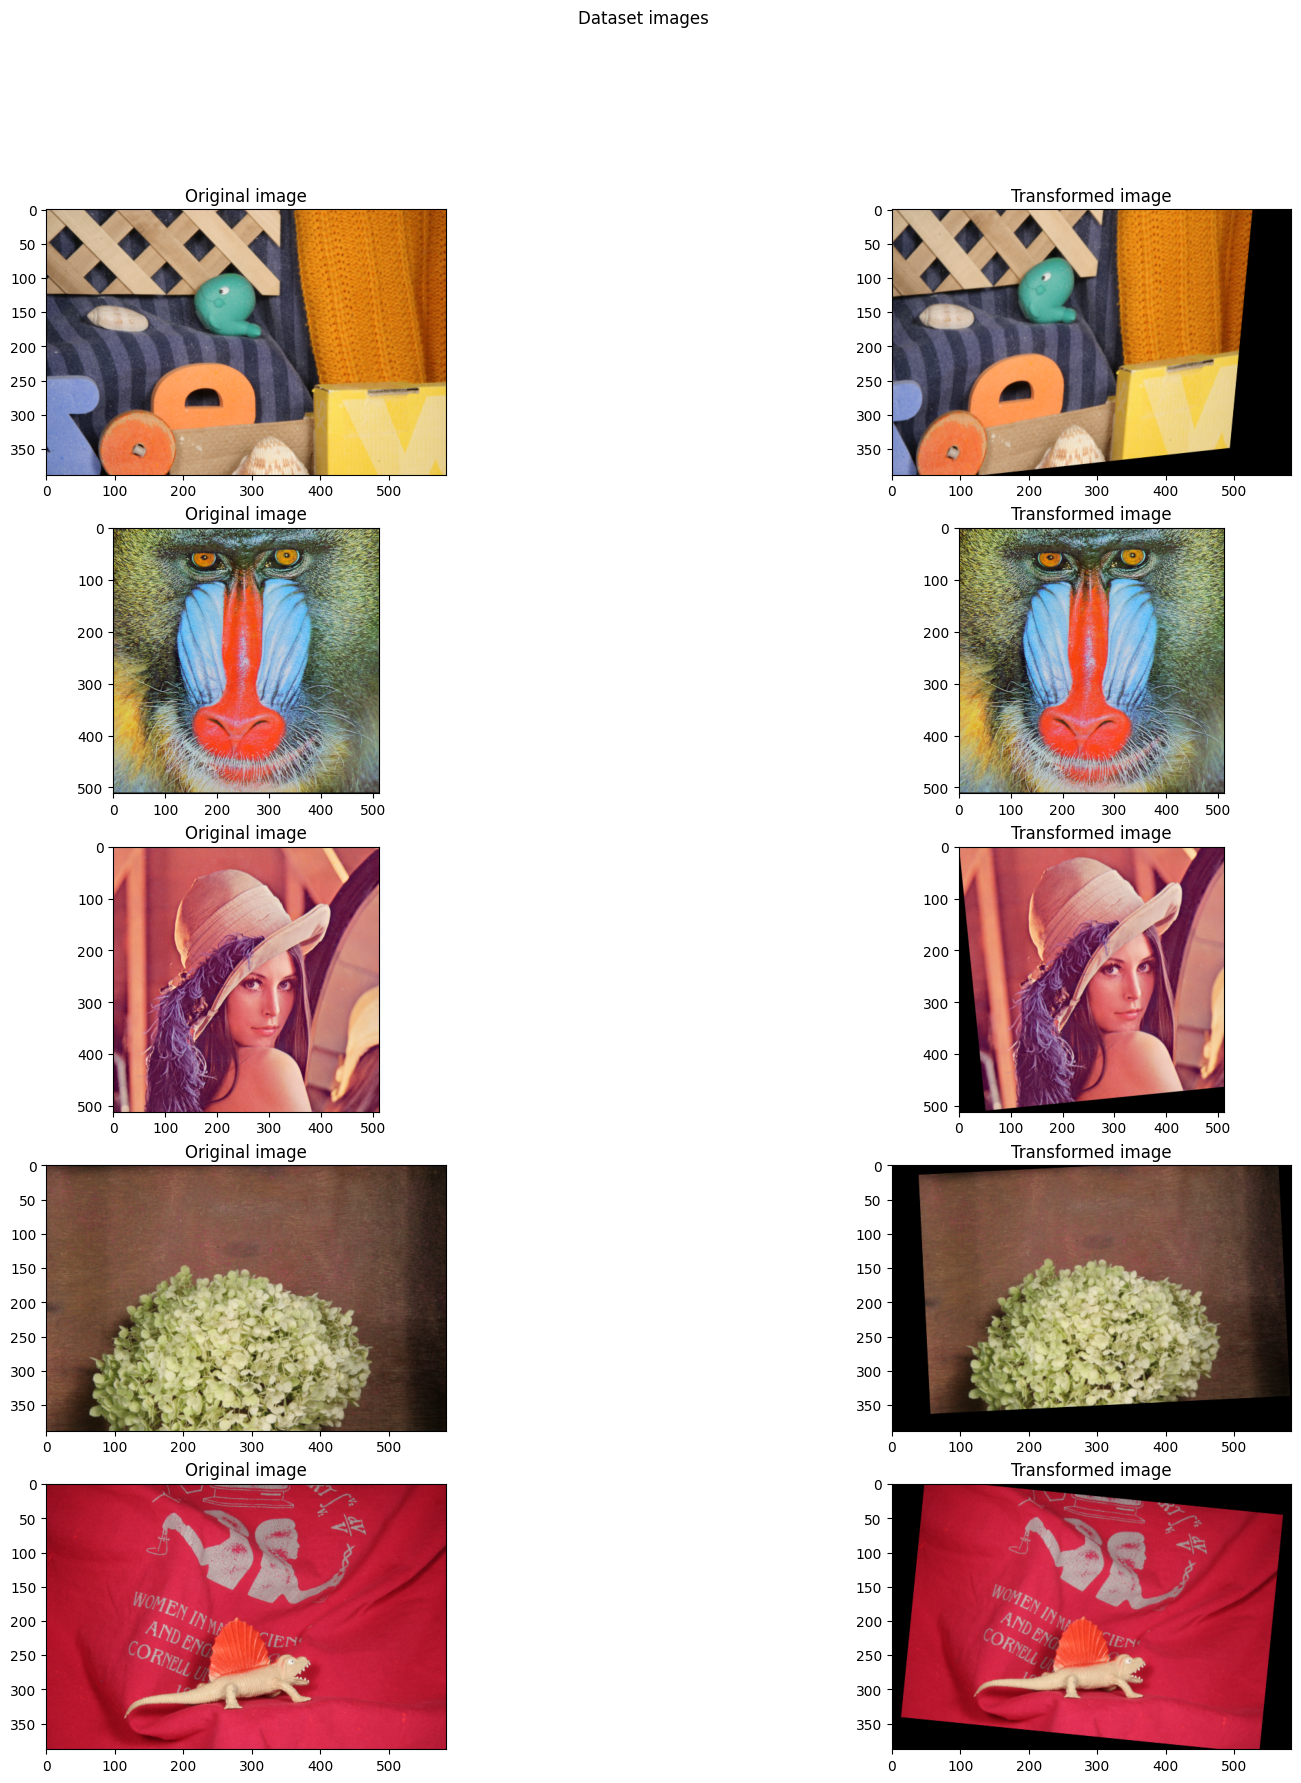

In [7]:
fig, axs = plt.subplots(5, 2, figsize=(20,20))
fig.suptitle("Dataset images")
i = 0
for sample in dataset:
    print("Dataset image: ", sample)
    print("\tFilename: ", dataset[sample]["filename"])
    original_image = imageio.imread(path.join(image_path, dataset[sample]["filename"]))
    print("\tImage shape: ", original_image.shape)
    print("i: ", i) 
    dataset[sample]["original_image"] = original_image
    transformation_type = dataset[sample]["transformation_type"]
    gt = dataset[sample]["gt"]
    # we generate the source image according to the ground truth
    # source_image = generate_source_image(original_image, transformation_type, gt)
    # we transform the source image to the target image according to the ground truth
    transformed_image = tf.transform_image(original_image, transformation_type, gt)
    dataset[sample]["transformed_image"] = transformed_image
    # output_img, debug_dict = inverse_compositional_algorithm(image, transformation_type, gt, params_ica)
    # output_img, debug_dict = robust_inverse_compositional_algorithm(image, transformation_type, gt, params_rica)
    # output_img, debug_dict = pyramidal_inverse_compositional_algorithm(image, transformation_type, gt, params_pica)

    # display the image
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original image")
    # axs[i][1].imshow(source_image)
    # axs[i][1].set_title("Source image")
    axs[i][1].imshow(transformed_image)
    axs[i][1].set_title("Transformed image")
    i += 1

plt.show()

### Test of the algorithm "Inverse compositional"

In [14]:

for sample in dataset:
    print("Processing dataset image: ", sample)
    original_image = dataset[sample]["original_image"]
    transformation_type = dataset[sample]["transformation_type"]
    p = np.zeros(transformation_type.nparams())
    gt = dataset[sample]["gt"]
    # we generate the source image according to the ground truth
    # source_image = generate_source_image(original_image, transformation_type, gt)
    # we transform the source image to the target image according to the ground truth
    transformed_image = dataset[sample]["transformed_image"]
    p = pyramidal_inverse_compositional_algorithm(
        original_image,
        transformed_image,
        p,
        transformation_type, 
        params_pica["pyramid_levels"], 
        params_pica["nu"],
        params_pica["TOL"],
        io.RobustErrorFunctionType.QUADRATIC, 
        0,  
        params_pica["verbose"]
    )




Processing dataset image:  rubber_whale


NameError: name 'RobustErrorFunctionType' is not defined